In [6]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

os.makedirs("media", exist_ok=True)
# Please comment out this option if your computer does not support LaTex fonts
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 20
})

## Load evaluation logs

The 1st step: Give your logging path to the `LOG_DIR` 

The 2nd step: Modify the **alias** to collect your logs

- Key: "prefix" of your experimental name

- Value: Alias of the key you want to display in the graphs further


In [7]:
df = None

LOG_DIR = "../../run/ppo_pendulum_calf_wrapper_eval/logs"
alias = {
    "energy_based_run": "EnergyBasedController",
    "pure_ppo_eval_500000": "VanillaPPO_welltrained",
    "pure_ppo_eval_200000": "VanillaPPO_undertrained",
    "pure_ppo_with_calfw_eval_200000": "VanillaPPO_undertrained+CALFWrapper",
    "pure_ppo_with_calfw_eval_500000": "VanillaPPO_welltrained+CALFWrapper",
}

for root, dirs, files in os.walk(LOG_DIR):
    for fn in files:
        
        if not fn.endswith(".csv") or "seed" not in fn:
            continue
        file_path = os.path.join(root, fn)

        tmp_df = pd.read_csv(file_path, sep=',')
        
        # Convert string to array
        for k in tmp_df:            
            tmp_df[k] = tmp_df[k].apply(lambda x: x if not isinstance(x, str) else np.fromstring(
                                        x.replace('\n','')
                                        .replace('[','')
                                        .replace(']','')
                                        .replace('  ',' '), sep=' '))
            
        tmp_df["action"] = tmp_df["action"].apply(lambda x: x[0] if not isinstance(x, float) else x)
        tmp_df["reward"] = tmp_df["reward"].apply(lambda x:  x[0] if not isinstance(x, float) else x)
        tmp_df["accumulated_reward"] = tmp_df["accumulated_reward"].apply(lambda x:  x[0] if not isinstance(x, float) else x)
        # if "relax_probability" in tmp_df.columns:
        #     tmp_df["relax_probability"] = tmp_df["relax_probability"].apply(lambda x: x[0] if x else x)

        tmp_df["x"] = tmp_df["state"].apply(lambda x: x[0])
        tmp_df["y"] = tmp_df["state"].apply(lambda x: x[1])
        tmp_df["angular_vel"] = tmp_df["state"].apply(lambda x: x[2])

        tmp_df["file_name"] = fn
        for k in alias:
            if k in fn:
                tmp_df["Case"] = alias[k]
                break

        if "Case" not in tmp_df:
            continue
        
        if df is None:
            df = tmp_df
        else:
            df = pd.concat([df, tmp_df])

Rename the 1st column to `step`

In [8]:
df.columns = ["step"] + df.columns[1:].tolist()
df.head()

,step,state,action,reward,accumulated_reward,x,y,angular_vel,file_name,Case,relax_probability,calf_activated_count
0,0,"[-0.7068149, 0.70739853, 1.2738186]",0.0,-5.304176,-5.304176,-0.706815,0.707399,1.273819,energy_based_run_seed_13.csv,EnergyBasedController,NaN,NaN
1,1,"[-0.76767415, 0.6408404, 1.8043675]",0.0,-5.711969,-11.016146,-0.767674,0.640840,1.804367,energy_based_run_seed_13.csv,EnergyBasedController,NaN,NaN
2,2,"[-0.83572614, 0.5491465, 2.284998]",0.0,-6.308491,-17.324637,-0.835726,0.549146,2.284998,energy_based_run_seed_13.csv,EnergyBasedController,NaN,NaN
3,3,"[-0.903577, 0.42842567, 2.7718577]",0.5,-7.077252,-24.401888,-0.903577,0.428426,2.771858,energy_based_run_seed_13.csv,EnergyBasedController,NaN,NaN
4,4,"[-0.95984674, 0.28052485, 3.168177]",0.5,-8.052323,-32.454211,-0.959847,0.280525,3.168177,energy_based_run_seed_13.csv,EnergyBasedController,NaN,NaN


Check and assign color to each case

In [10]:
import matplotlib.colors as mcolors

color_list = list(mcolors.TABLEAU_COLORS.keys())
case_colors = {c:color_list[i] for i, c in enumerate(alias.values())}
case_colors

{'EnergyBasedController': 'tab:blue',
 'VanillaPPO_welltrained': 'tab:orange',
 'VanillaPPO_undertrained': 'tab:green',
 'VanillaPPO_undertrained+CALFWrapper': 'tab:red',
 'VanillaPPO_welltrained+CALFWrapper': 'tab:purple'}

Ensure the number of runs for each case

In [11]:
n_runs = df.loc[:, ["Case", "file_name"]].groupby(["Case"]).nunique().values[0]
df.loc[:, ["Case", "file_name"]].groupby(["Case"]).nunique(), int(n_runs[0])

(                                     file_name
 Case                                          
 EnergyBasedController                        3
 VanillaPPO_undertrained                      3
 VanillaPPO_undertrained+CALFWrapper          3
 VanillaPPO_welltrained                       3
 VanillaPPO_welltrained+CALFWrapper           3,
 3)

## Statistical table and Box plot of accumulated rewards

In [12]:
# df.loc[:, ["Case", "file_name"]].groupby(["Case"]).nunique()
def first_quartile(series):
    return series.quantile(q=[0.25])

def third_quartile(series):
    return series.quantile(q=[0.75])

def interquartile_range(series):
    quarters = series.quantile(q=[0.25, .75])
    return quarters[0.75] - quarters[0.25]

group_df = df.loc[:, ["Case", "file_name", "accumulated_reward"]].groupby(["Case", "file_name"]).last()
group_df = group_df.reset_index().drop(columns=["file_name"])
group_df.columns = ["last_accumulated_reward" if column == "accumulated_reward" else column for column in group_df.columns]
group_df.groupby("Case").agg({
    "last_accumulated_reward": ["std", "var", first_quartile, third_quartile, interquartile_range, "min", "mean", "median", "max"]
})

last_accumulated_reward                \
                                                        std           var   
Case                                                                        
EnergyBasedController                            867.365928  7.523237e+05   
VanillaPPO_undertrained                         4006.308596  1.605051e+07   
VanillaPPO_undertrained+CALFWrapper              113.982241  1.299195e+04   
VanillaPPO_welltrained                          2908.347658  8.458486e+06   
VanillaPPO_welltrained+CALFWrapper                76.236619  5.812022e+03   

                                                                   \
                                    first_quartile third_quartile   
Case                                                                
EnergyBasedController                 -2374.378686   -1520.974314   
VanillaPPO_undertrained               -5832.965227   -1851.591074   
VanillaPPO_undertrained+CALFWrapper    -303.490660    -189.588465   
VanillaPPO_welltrained                -2734.712249    -190.390773   
VanillaPPO_welltrained+CALFWrapper     -312.861285    -246.103915   

                                                                      \
                                    interquartile_range          min   
Case                                                                   
EnergyBasedController                        853.404372 -2935.313781   
VanillaPPO_undertrained                     3981.374153 -8210.144627   
VanillaPPO_undertrained+CALFWrapper          113.902195  -364.140530   
VanillaPPO_welltrained                      2544.321476 -5226.990091   
VanillaPPO_welltrained+CALFWrapper            66.757370  -378.124240   

                                                                            
                                            mean       median          max  
Case                                                                        
EnergyBasedController               -1992.420803 -1813.443591 -1228.505038  
VanillaPPO_undertrained             -3971.108925 -3455.785827  -247.396322  
VanillaPPO_undertrained+CALFWrapper  -247.772487  -242.840790  -136.336140  
VanillaPPO_welltrained              -1869.257213  -242.434408  -138.347139  
VanillaPPO_welltrained+CALFWrapper   -290.110690  -247.598330  -244.609500

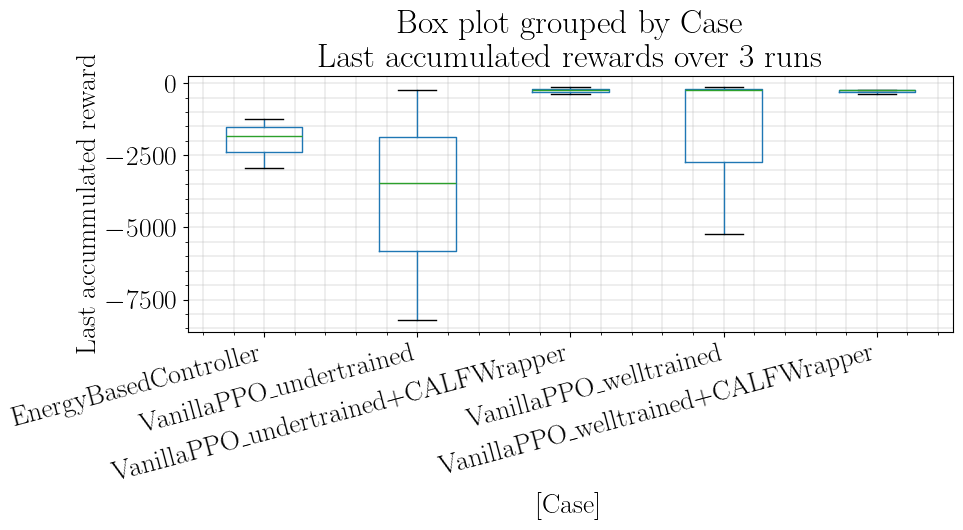

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))
p = group_df.boxplot(by="Case",ax=ax)
p.set_xticklabels([l for l in p.get_xticklabels()], rotation=15, ha="right")
p.minorticks_on()

ax.set_ylabel("Last accummulated reward")
ax.set_title(f"Box plot grouped by Case\nLast accumulated rewards over {int(n_runs[0])} runs")
ax.grid(visible=True, which="both", linewidth=0.3)
fig.suptitle("")
plt.tight_layout()

## Accumulated reward comparison and their 95% Confidence Interval

Text(0.5, 1.0, 'Acumulated Reward Comparison')

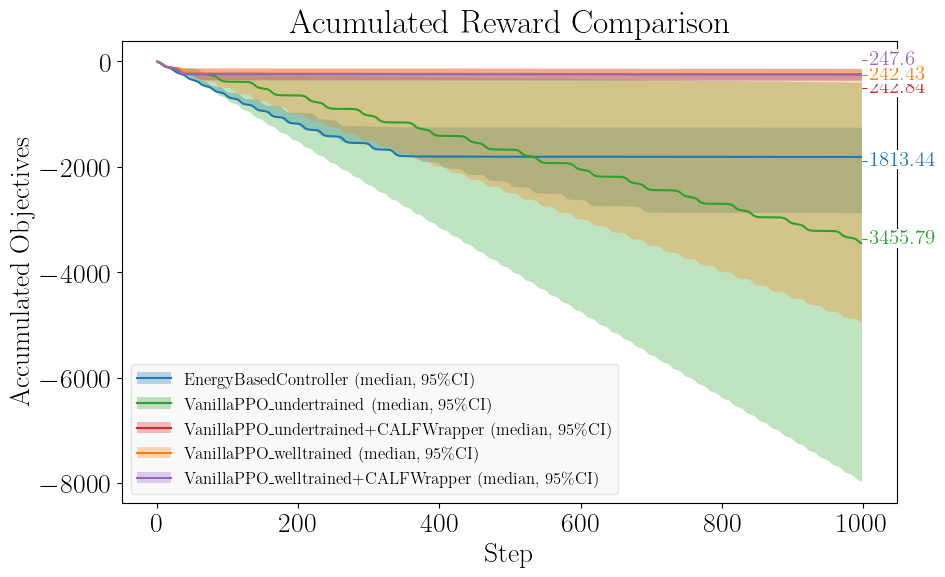

In [14]:
from scipy.interpolate import interp1d

def plot_ic(df, ax, 
            y_label="accumulated_reward",
            low_quantile=0.025, 
            high_quantile=0.975, 
            color=None, 
            use_interpolate=False,
            is_truncate=True):
    def quantile_low(series):
        return series.quantile(low_quantile)

    def quantile_high(series):
        return series.quantile(high_quantile)

    tmp_df = df.copy()
    ic_95_df = tmp_df.groupby("step").agg({y_label: [quantile_low, quantile_high]})

    # Plot
    if not use_interpolate:
        X_ = ic_95_df.index
        Y_hi = ic_95_df[y_label].quantile_high
        Y_lo = ic_95_df[y_label].quantile_low
    else:
        cubic_interpolation_model_hi = interp1d(ic_95_df.index, 
                                                ic_95_df[y_label].quantile_high, kind = "cubic")
        
        cubic_interpolation_model_lo = interp1d(ic_95_df.index, 
                                                ic_95_df[y_label].quantile_low, kind = "cubic")
    
        # Plotting the Graph
        X_=np.linspace(ic_95_df.index.min(), ic_95_df.index.max(), 40)
        Y_hi=cubic_interpolation_model_hi(X_)
        Y_lo=cubic_interpolation_model_lo(X_)
    
    p = ax.fill_between(X_, 
                        Y_hi, Y_lo, 
                        facecolor=color,
                        alpha=0.3)
    
    ax.set_xlabel("Step")
    ax.set_ylabel("Accumulated Objectives")

    return p

def plot_solid(df, ax, 
            y_label="accumulated_reward",
            low_quantile=0.025, 
            high_quantile=0.975, 
            color=None, 
            use_interpolate=False,
            is_truncate=True,
            bias=[0,0],
            agg_func="mean"):
    tmp_df = df.copy()
    target_df = tmp_df.loc[:, ["step", y_label]].groupby("step").agg(agg_func)

    # Plot
    if not use_interpolate:
        X_ = target_df.index
        Y_ = target_df[y_label]
    else:
        cubic_interpolation_model_mean = interp1d(target_df.index, 
                                                  target_df[y_label], kind = "cubic")
    
        # Plotting the Graph
        X_=np.linspace(target_df.index.min(), target_df.index.max(), 40)
        Y_=cubic_interpolation_model_mean(X_)
    
    p = ax.plot(X_, 
                Y_,
                color=color,
                alpha=1)

    ax.annotate(str(Y_.values[-1].round(2)), 
        (
            X_.values[-1] + bias[0], # X
            Y_.values[-1] + bias[1], # Y
            ),
            color=color,
            bbox=dict(facecolor='white', edgecolor="None", pad=0.2),
            fontsize=15)
    
    ax.set_xlabel("Step")
    ax.set_ylabel("Accumulated Objectives")
    
    return p[0]

tmp_df = df.set_index(["Case"])
y_label = "accumulated_reward"

fig, ax = plt.subplots(figsize=(10, 6))

legend_info = {}

anotation_bias = {
    "EnergyBasedController": [0, -150],
    "VanillaPPO_undertrained": [0, 0],
    "VanillaPPO_undertrained+CALFWrapper": [0, -350],
    "VanillaPPO_welltrained": [0, -100],
    "VanillaPPO_welltrained+CALFWrapper": [0, 200],
}

agg_func = "median"

# for c in tmp_df.index.unique():
for c in [
    "EnergyBasedController",
    "VanillaPPO_undertrained",
    "VanillaPPO_undertrained+CALFWrapper",
    "VanillaPPO_welltrained",
    "VanillaPPO_welltrained+CALFWrapper",
]:
    p_m = plot_solid(tmp_df.loc[c], y_label=y_label, 
                     ax=ax, 
                     color=case_colors[c], 
                     bias=anotation_bias[c],
                     agg_func=agg_func)
    p_ic = plot_ic(tmp_df.loc[c], y_label=y_label, ax=ax, color=case_colors[c])

    legend_info[c + f" ({agg_func}, 95\%CI)"] = (p_m, p_ic)

legend = ax.legend(legend_info.values(), 
                   legend_info.keys(),
                   facecolor='whitesmoke', 
                   framealpha=0.5,
                   prop={'size': 12})

ax.set_title("Acumulated Reward Comparison")


Text(0.5, 1.0, 'Acumulated Reward Comparison')

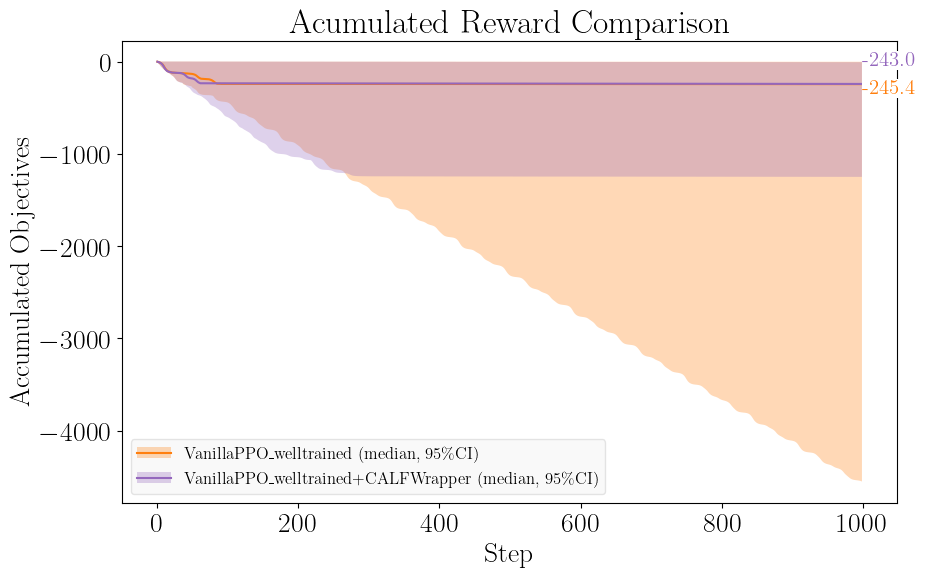

In [12]:
tmp_df = df.set_index(["Case"])
y_label = "accumulated_reward"

fig, ax = plt.subplots(figsize=(10, 6))

legend_info = {}

anotation_bias = {
    "VanillaPPO_welltrained": [0, -100],
    "VanillaPPO_welltrained+CALFWrapper": [0, 200],
}

agg_func = "median"

# for c in tmp_df.index.unique():
for c in [
    "VanillaPPO_welltrained",
    "VanillaPPO_welltrained+CALFWrapper",
]:
    p_m = plot_solid(tmp_df.loc[c], y_label=y_label, 
                     ax=ax, 
                     color=case_colors[c], 
                     bias=anotation_bias[c],
                     agg_func=agg_func)
    p_ic = plot_ic(tmp_df.loc[c], y_label=y_label, ax=ax, color=case_colors[c])

    legend_info[c + f" ({agg_func}, 95\%CI)"] = (p_m, p_ic)

legend = ax.legend(legend_info.values(), 
                   legend_info.keys(),
                   facecolor='whitesmoke', 
                   framealpha=0.5,
                   prop={'size': 12})

ax.set_title("Acumulated Reward Comparison")

## Plot relax probability and CALF activation for each run

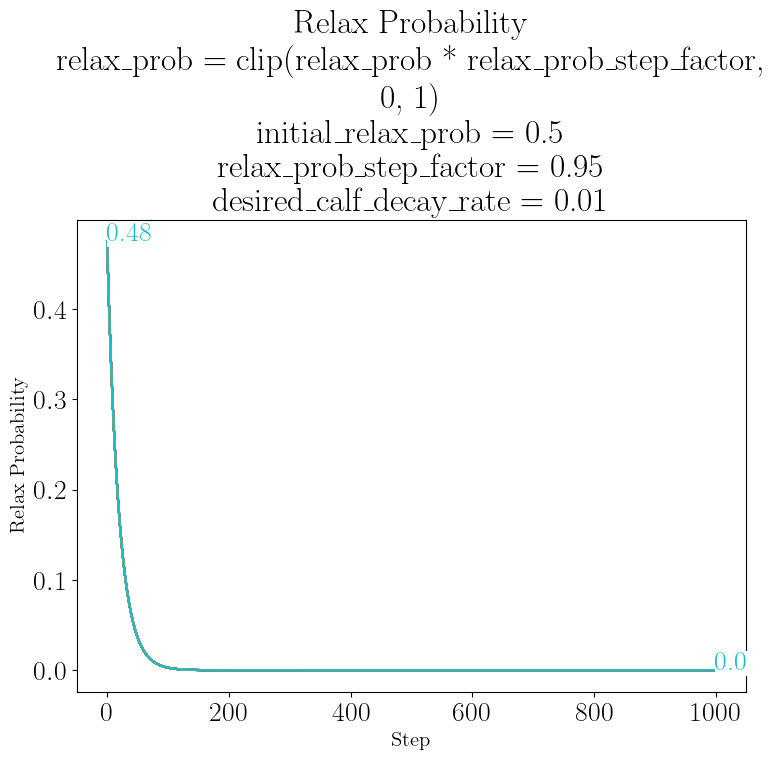

In [15]:
def plot_relax_prob(df, ax=None, c = "VanillaPPO_undertrained+CALFWrapper"):
    y_label = "relax_probability"

    if ax is None:
        fig, _ax = plt.subplots(figsize=(8, 8))
    else:
        _ax = ax
    tmp_df = df.set_index(["Case"])
    target_df = tmp_df.loc[c]

    for individual_run in tmp_df.loc[c].file_name.unique():
        target_df = tmp_df.loc[c]
        target_df = target_df[target_df.file_name == individual_run]
        
        target_df.plot(x="step", y=y_label, ax=_ax)

        current_color = _ax.get_lines()[-1].get_color() 
        _ax.annotate(str(target_df[y_label].values[0].round(2)), 
                            (
                                target_df.step.values[0], # X
                                target_df[y_label].values[0], # Y
                            ),
                            color=current_color,
                            bbox=dict(facecolor='white', edgecolor="None", pad=0.2))
        
        _ax.annotate(str(target_df[y_label].values[-1].round(2)), 
                        (
                            target_df.step.values[-1], # X
                            target_df[y_label].values[-1], # Y
                        ),
                        color=current_color,
                        bbox=dict(facecolor='white', edgecolor="None", pad=0.2))

    _ax.set_xlabel("Step", fontsize=15)
    _ax.set_ylabel("Relax Probability", fontsize=15)
    _ax.get_legend().remove() 
    _ax.set_title("Relax Probability\n" + 
                 "relax_prob = clip(relax_prob * relax_prob_step_factor,\n 0, 1)\n" + 
                 "initial_relax_prob = 0.5\nrelax_prob_step_factor = 0.95\n" +
                 "desired_calf_decay_rate = 0.01")
    plt.tight_layout()

    if ax is None:
        fig.savefig("media/" + "relax_probability.png")
# relax_prob = np.clip(relax_prob * relax_prob_step_factor, 0, 1)
plot_relax_prob(df)

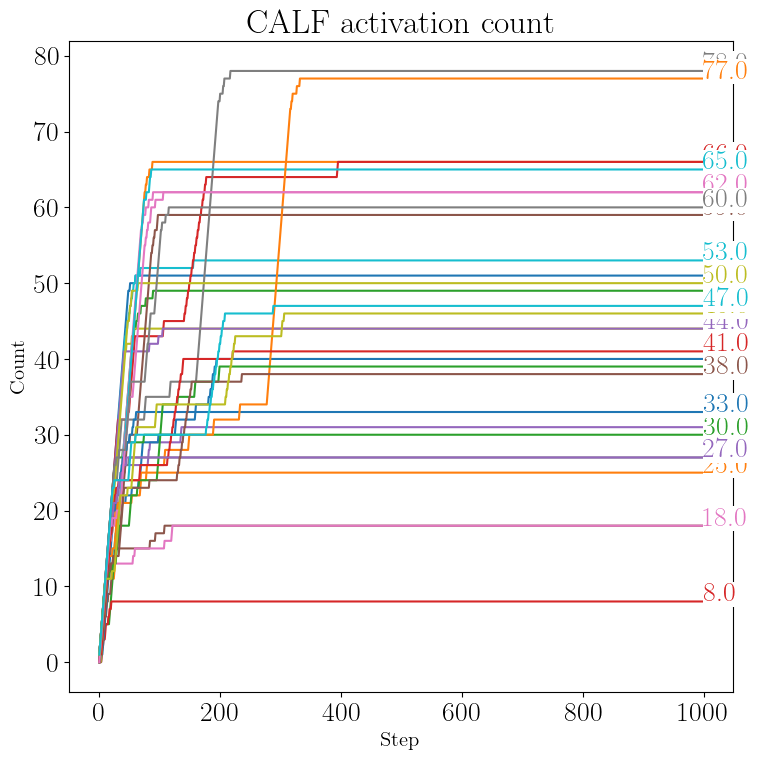

In [16]:
def plot_activated_count(df, ax=None, c="VanillaPPO_welltrained+CALFWrapper"):
    y_label = "calf_activated_count"

    if ax is None:
        fig, _ax = plt.subplots(figsize=(8, 8))
    else:
        _ax = ax
    tmp_df = df.set_index(["Case"])

    for individual_run in tmp_df.loc[c].file_name.unique():
        target_df = tmp_df.loc[c]
        target_df = target_df[target_df.file_name == individual_run]

        target_df.plot(x="step", y=y_label, ax=_ax)

        current_color = _ax.get_lines()[-1].get_color() 
        
        _ax.annotate(str(target_df[y_label].values[-1].round(2)), 
                        (
                            target_df.step.values[-1], # X
                            target_df[y_label].values[-1].copy(), # Y
                        ),
                        color=current_color,
                        bbox=dict(facecolor='white', edgecolor="None", pad=0.2))

    _ax.set_xlabel("Step", fontsize=15)
    _ax.set_ylabel("Count", fontsize=15)
    _ax.get_legend().remove() 
    _ax.set_title("CALF activation count")

    plt.tight_layout()
    
    if ax is None:
        fig.savefig("media/" + "relax_probability.png")
# relax_prob = np.clip(relax_prob * relax_prob_step_factor, 0, 1)
plot_activated_count(df)

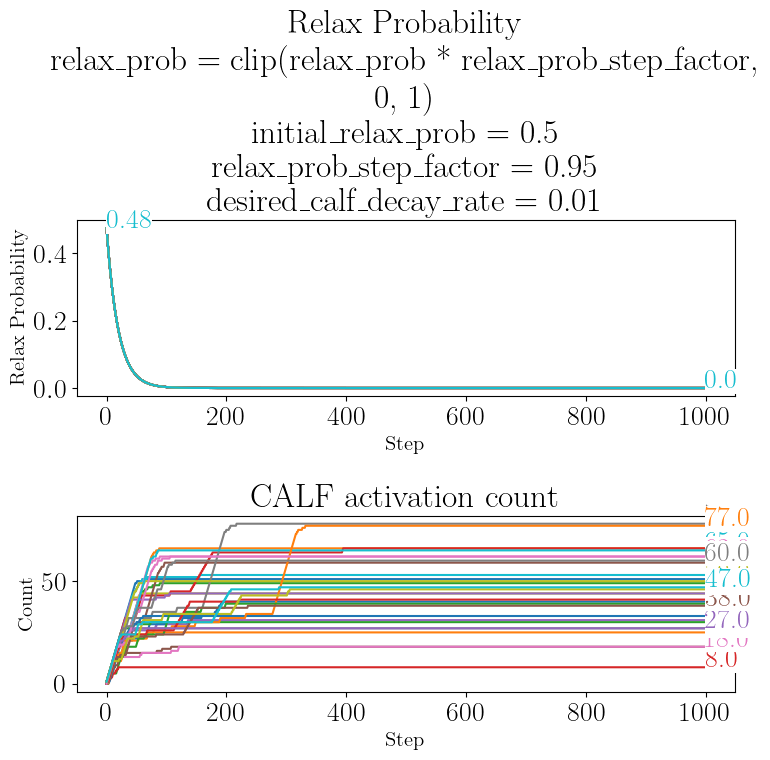

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8))
c = "VanillaPPO_welltrained+CALFWrapper"
# c = "VanillaPPO_undertrained+CALFWrapper"
plot_relax_prob(df, ax[0], c=c)
plot_activated_count(df, ax[1], c=c)